# Self-Driving Car Engineer Nanodegree

## Project 4: Advaned Laneline Detection
---

## Goals

Dtetect lane lines and calculate curvatures.

## Steps

1. Camera Calibration
2. Distortion correction
3. Color and gradient threshold
4. Warp perspective transform
5. Find lane lines
6. Sanity checking

### Camera Calibration

1. Convert color image to grayscale
2. Find corners
3. Get calibration matrix

In [1]:
### TODO:
# 1. Count nx and ny
# 2. Convert color image to grayscale
# 3. Get corners


import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


### Distortion Correction

Execute calibration and distortion correction once. Save the results for later usage.

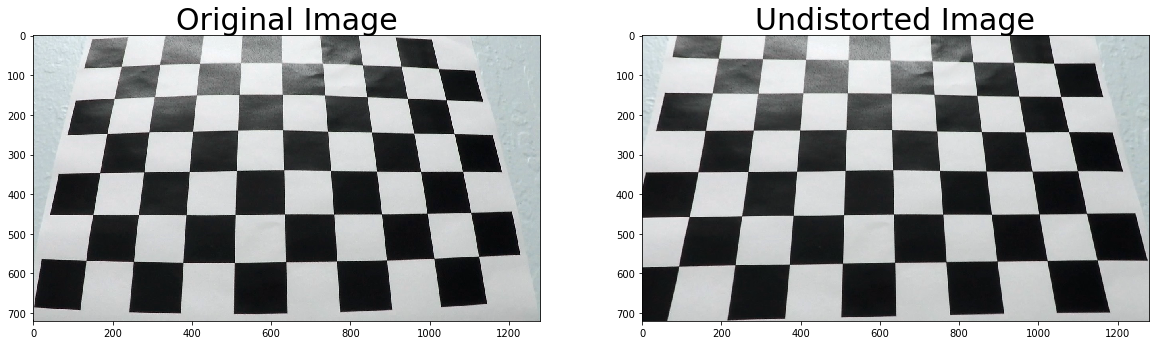

In [2]:
###

import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/calibration3_test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

plt.savefig('output_images/calibration3_test_undist.png', bbox_inches='tight')

### Color & Gradient Threshold

Create a pipeline to process an image.

#### Define some preprocessing functions below

In [3]:
###

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


### Use color transforms and gradients to create a thresholded binary image

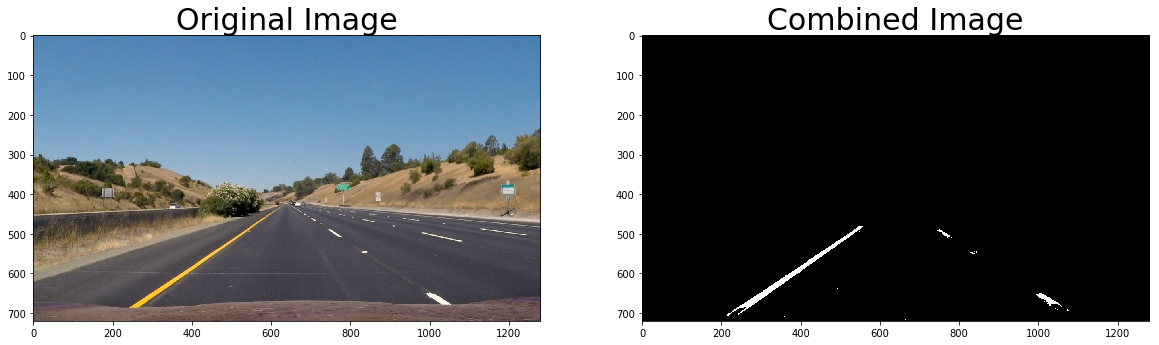

In [4]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Load a test image
img = mpimg.imread('test_images/straight_lines1.jpg')

imshape = img.shape
vertices = np.array([[(50,imshape[0]),(500, 480), (800,480), (1200,imshape[0])]], dtype=np.int32)

# Undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)

# grayscale image
gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

# sobel operation applied to x axis
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

# Get absolute values
abs_sobelx = np.absolute(sobelx)

# Scale to (0, 255)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# threshold
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
# plt.imshow(sxbinary, cmap='gray')


# Get HLS color image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)

# Get s-channel
s_channel = hls[:, :, 2]

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


# Combine grayscale and color gradient
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

combined_binary = region_of_interest(combined_binary, vertices)

kernel_size = 5
combined_binary = gaussian_blur(combined_binary, kernel_size)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Image', fontsize=30)

plt.savefig('output_images/test1_straight_binary.png', bbox_inches='tight')

### Warp perspective

Test the warped area

1280 720


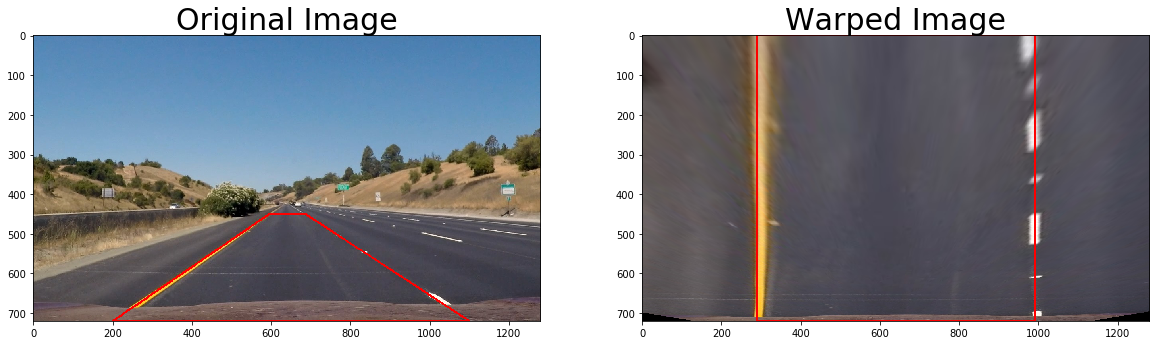

In [5]:
height = combined_binary.shape[0]
width = combined_binary.shape[1]
print(width, height)

# Set the view of perspective
pts_list = [[200,height],[595, 450], [686,450], [1100,height]]
pts_list_dst = [[290,height],[290,0],[989,0],[989,height]]
pts = np.array(pts_list, np.int32)
pts = pts.reshape((-1,1,2))
tmp = np.copy(img)

# Draw the ROI on the image
cv2.polylines(tmp,[pts],True,(255,0,0), thickness=3)

points_src = np.float32(pts_list)
points_dst = np.float32(pts_list_dst)

M = cv2.getPerspectiveTransform(points_src, points_dst)
Minv = cv2.getPerspectiveTransform(points_dst, points_src)

warped = cv2.warpPerspective(img, M, (width, height))

pts_dst = np.array(pts_list_dst, np.int32)
pts_dst = pts_dst.reshape((-1,1,2))

cv2.polylines(warped,[pts_dst],True,(255,0,0), thickness=3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(tmp)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

plt.savefig('output_images/test1_straight_unwarp.png', bbox_inches='tight')

In [6]:
# Save the perspective transform matrix and other constants together
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )


## Wrap the procedures above into a function

Create a function called `preprocessPT` to perform above functionalities.

In [7]:
### TODO: create a function to preprocess image and return the warped image

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def preprocessPT(img, mtx, dist, M, sx_thresh=(20,100), s_thresh=(170,255)):
    '''img: RGB image
    mtx: camera matrix
    dist: distortion coefficients
    M: perspective transform matrix
    sx_thresh: threshold for grayscale gradient
    s_thresh: threshold for HLS color gradient'''
    
    # Undistortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)    
    # grayscale image
    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)    
    # sobel operation applied to x axis
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Get absolute values
    abs_sobelx = np.absolute(sobelx)
    # Scale to (0, 255)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    # Get HLS color image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # Get s-channel
    s_channel = hls[:, :, 2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine grayscale and color gradient
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    kernel_size = 5
    combined_binary = gaussian_blur(combined_binary, kernel_size)

    height = combined_binary.shape[0]
    width = combined_binary.shape[1]
    warped = cv2.warpPerspective(combined_binary, M, (width, height))
    return warped

Test the function above

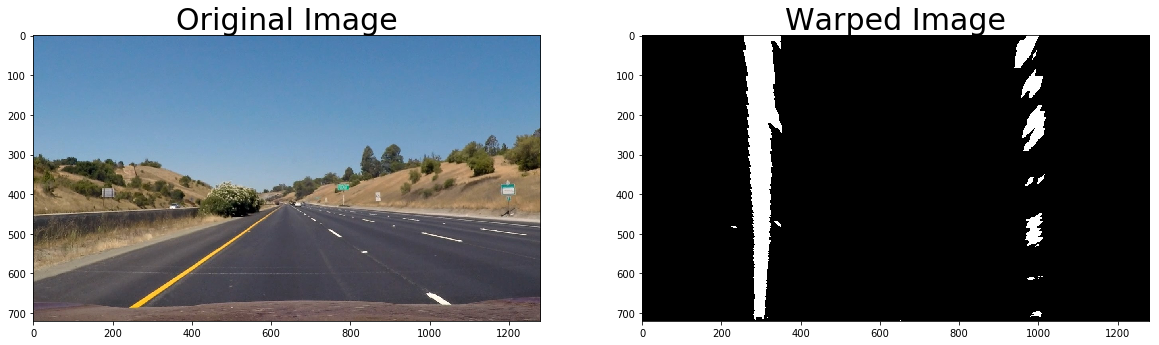

In [8]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]

# Load a test image
img = mpimg.imread('test_images/straight_lines1.jpg')
tmp = preprocessPT(img, mtx, dist, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(tmp, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

plt.savefig('output_images/perp_straight.png', bbox_inches='tight')

**Test curved lanes**

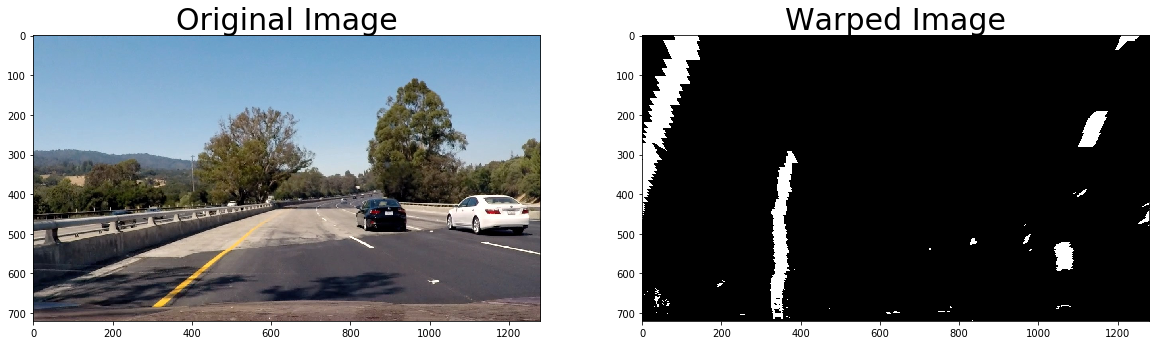

In [9]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]

# Load a test image
img = mpimg.imread('test_images/test4.jpg')
tmp = preprocessPT(img, mtx, dist, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(tmp, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

plt.savefig('output_images/perp_curved.png', bbox_inches='tight')

### Find lane lines



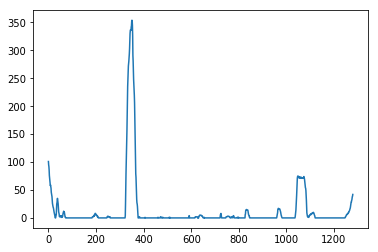

In [10]:
# Show the hist
histogram = np.sum(tmp[tmp.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Fit lane lines using polynomials

In [19]:
def initializeLD(binary_warped):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def detectLD():
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def visualize(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result 
'''
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)    
'''


"\n    plt.imshow(result)\n    plt.plot(left_fitx, ploty, color='yellow')\n    plt.plot(right_fitx, ploty, color='yellow')\n    plt.xlim(0, 1280)\n    plt.ylim(720, 0)    \n"

### Test the functions

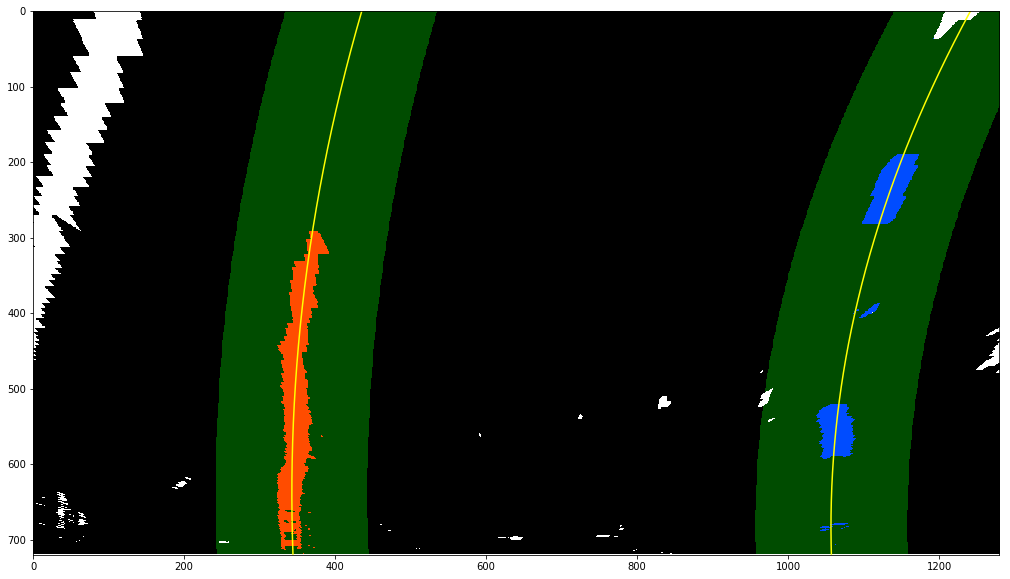

In [21]:
binary_warped = tmp
left_fit, right_fit, left_lane_inds, right_lane_inds = initializeLD(tmp)
out_img = visualize(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('output_images/test_straight1_fit.png', bbox_inches='tight')

## Video Pipeline

Wrap above functions into a class called `Detector`


### Test an image

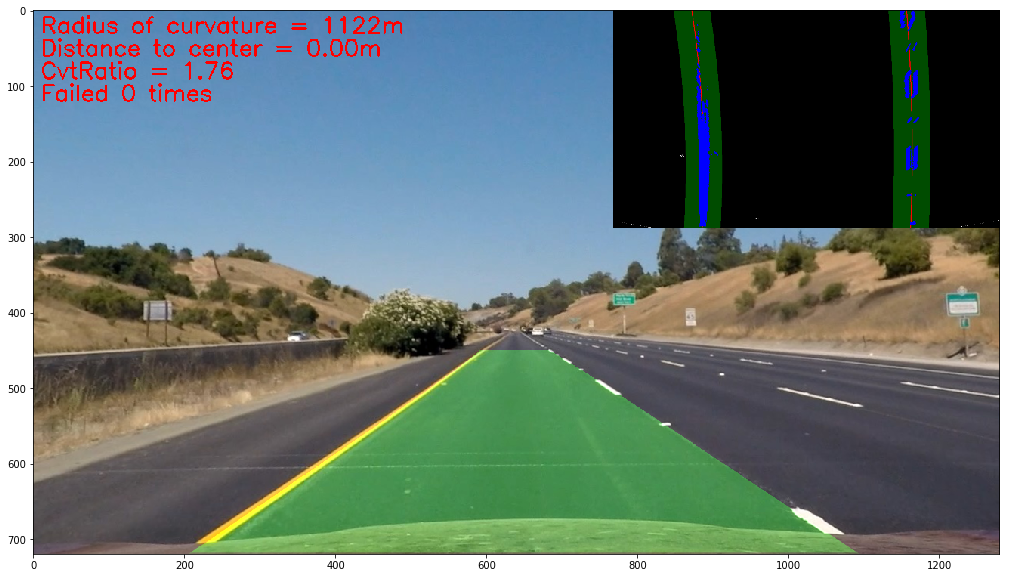

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from detector import Detector
%matplotlib inline


dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

detector = Detector(mtx=mtx, dist=dist, M=M, Minv=Minv, sx_thresh=(20,100), s_thresh=(170,255))
detector.LeftLine.N = 5
detector.RightLine.N = 5
q=[10, 10, 20]
R=[1, 1, 1]
detector.setKF_PR(q, R)
detector.setMargin(60)
detector.setBinaryFun(flag=5)
detector.switchKF(False)
img = mpimg.imread('test_images/straight_lines1.jpg')

result = detector.detect(img)

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.savefig('output_images/test_straight1_detect.png', bbox_inches='tight')

### Test a video

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from detector import Detector, print_prof_data
%matplotlib inline


dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

detector = Detector(mtx=mtx, dist=dist, M=M, Minv=Minv, sx_thresh=(20,100), s_thresh=(170,255))
# Set number of buffers
detector.LeftLine.N = 5
detector.RightLine.N = 5
# Parameters of Kalman filter. KF is not adoppted here and forget those parameters
q=[10, 10, 20]
R=[1, 1, 1]
detector.setKF_PR(q, R)
# Set margins
detector.setMargin(60)
# Set color transforms
detector.setBinaryFun(flag=5)
# Turn off Kalman filter
detector.switchKF(False)

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/project_output_v2_kf.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./project_video.mp4")#.subclip(18,48)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(detector.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output_v2_kf.mp4
[MoviePy] Writing video output_images/project_output_v2_kf.mp4


100%|█████████▉| 1260/1261 [02:37<00:00,  8.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output_v2_kf.mp4 

CPU times: user 5min 27s, sys: 20.2 s, total: 5min 47s
Wall time: 2min 38s


In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Plot coefficients of polynomials

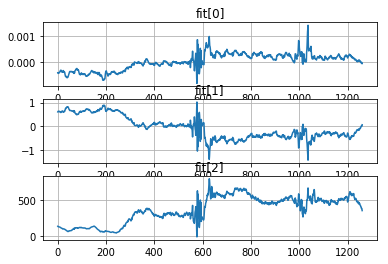

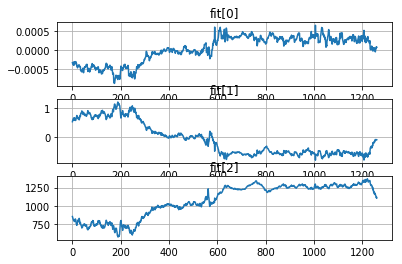

In [4]:
detector.plotFit()

### Display elapsed time

In [5]:
print_prof_data()

Function detect called 1261 times. 
Execution time max: 0.145, average: 0.108
Function _undistort called 1261 times. 
Execution time max: 0.048, average: 0.033
Function performBinary called 1261 times. 
Execution time max: 0.046, average: 0.034
Function _warp called 1261 times. 
Execution time max: 0.030, average: 0.006
Function get_xy_pvalue called 1261 times. 
Execution time max: 0.016, average: 0.011
Function getCurvature called 2522 times. 
Execution time max: 0.001, average: 0.000
Function visualizeDetection called 1261 times. 
Execution time max: 0.008, average: 0.005
Function visualizeInput called 1261 times. 
Execution time max: 0.020, average: 0.011
